In [36]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

For my machine learning notebook I will be using unsupervised learning. I have opted for this method as there is no target variable to predict. The primary focus is to discover patterns in the data, in this case student's use of social media. These patterns could then be further analysed and used by social media companies who want to target certain demographics, or health professionals looking for causation of poor mental health scores.

Before I can run the data through my ml model I will have to modify the data and select the optimal number of clusters.

## 1.1 Load and inspect the dataset

In [37]:
# Load the data
df_ml = pd.read_csv('../data/cleaned_data/student_social_media_addiction_cleaned.csv')

## 1.2 Column management

Not all columns will be used in the model, some of the time columns are too similar to each other so I will be dropping the hour columns and using the minute ones going forward.

In [38]:
# Check column names to assign them as numerical or categorical
df_ml.columns

Index(['new_student_id', 'age', 'gender', 'relationship_status',
       'academic_level', 'country', 'continents', 'most_used_platform',
       'average_daily_usage_minutes', 'average_daily_use_by_hour',
       'sleep_per_night_minutes', 'sleep_hours_per_night',
       'conflicts_over_social_media', 'affects_academic_performance',
       'addicted_score', 'mental_health_score'],
      dtype='object')

In [39]:
# Drop unnecessary columns
df_ml = df_ml.drop(columns=['new_student_id', 'average_daily_use_by_hour', 'sleep_hours_per_night'])

In [40]:
# Numerical and categorical columns
num_cols = ['age', 'average_daily_usage_minutes', 'sleep_per_night_minutes', 'conflicts_over_social_media', 'addicted_score', 'mental_health_score']
cat_cols = ['gender', 'relationship_status', 'academic_level', 'country', 'continents', 'most_used_platform', 'affects_academic_performance']

## 1.3 Encode categoricals and scale numerical columns
I will need to encode the categorical ones from string to numerical so that they are useable. Numerical columns will also be scaled so that they do not distort the data. Standard scaler gives all columns a mean of 0 and standard deviation of 1. 

In [41]:
# Encode categoricals and scale numerical columns
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), num_cols),
    ('categorical', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

## 1.4 Create pipeline
A pipeline has been created and will be refined throughout this notebook to get the best clusters. By using a pipeline multiple steps can be bundled together to transform and model the data, reducing errors and making it reusable. Pipelines are useful when experimenting with different PCA components or cluster numbers to efficiently refine the analysis.
As I have already cleaned the data in a previous notebook I will not be including a data cleaning or feature engineering step in this pipeline. 

The preprocessor has been created in the cell scaling the numerical columns. Categorical columns have then been encoded, the first value has been dropped for efficiency. The PCA components and kmeans are still to be refined to both have been set to 10.
To make the pipeline reusable and to get results of different clusters and components it has been put into a function

In [42]:
def create_pipeline(n_components=10, n_clusters=10):
    '''
    A pipeline created to scale and encode categoricals, 
    set number of PCA components and clusters to be used with different parameters.
    '''
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=n_components)),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42, n_init=10))
    ])
    return pipeline


## 1.5 Principal component analysis (PCA)
Here we are trying to find the optimal number of principal components. The default number gives us a result of 86.14% meaning they summarise most of the data but have discarded some values. We are aiming to get a value between 85-95% with as few as components as possible.

In [43]:
# Apply preprocessor to the data
X_processed = preprocessor.fit_transform(df_ml)

# Define range of n_components to test
component_range = range(9, 14)

results = {}

for n_components in component_range:
    pca = PCA(n_components=n_components).fit(X_processed)
    explained_variance = np.round(100 * pca.explained_variance_ratio_.sum(), 2)
    results[n_components] = explained_variance

df_variance_summary = pd.DataFrame.from_dict(
    results, orient='index', columns=['Explained Variance (%)']
)
df_variance_summary.index.name = 'Number of Components'

print(df_variance_summary)

                      Explained Variance (%)
Number of Components                        
9                                      84.80
10                                     86.14
11                                     87.09
12                                     87.95
13                                     88.77


Looking at those results, the largest jump in variance is from 9 to 10. Adding more than that make little change to the variance but increases dimensionality, something we're trying to reduce. We will be using 10 components as it allows us to retain the majority of the dataset's information and reduce dimensionality to simplify KMeans

In [44]:
# Update cluster pipeline, n_components to 10

def create_pipeline(n_components=10, n_clusters=10):
    '''
    A pipeline created to scale and encode categoricals, 
    set number of PCA components and clusters to be used with different parameters.
    '''
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # assumes 'preprocessor' is already defined
        ('pca', PCA(n_components=n_components)),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42, n_init=10))
    ])
    return pipeline


In [45]:
# Apply pipeline to df_ml

pipeline_analysis = Pipeline(pipeline.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_ml)

print(df_analysis.shape, type(df_analysis))

(702, 10) <class 'numpy.ndarray'>


## 1.6 Finding the right amount of clusters (KMeans)
We are now interested in finding the most suitable value for n_clusters, which we will then update on the ML Pipeline for Cluster. We will combine two techniques, Elbow method and silhouette score, to find the optimal number of clusters. Both suggest values (which may be different), and we will use them in conjunction to decide on the optimal number of clusters.

The elbow method is plotted on a line chart, the x-axis plotting the number of clusters and the y-axis plots inertia which is the sum of squared distances of each point to it's clusters centroid. By examining the chart for the point where the line pivots most like an elbow will be the number of clusters, on the plot below it would be either 3, 4 or 5.

The silhouette score interprets and validates consistency within the clusters. The scores will range from -1 to 1. A negative score indicates that a point may be in the wrong cluster, a score close to zero means there is overlap amongst clusters. There is also a line representing the mean, the higher the mean line the better defined the clusters.

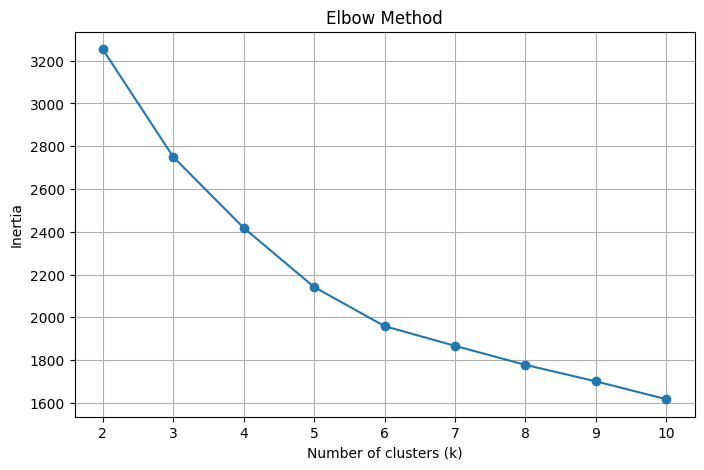

In [46]:
X_pca = pipeline_analysis.fit_transform(df_ml)

# Iterate over values 2-10 to suggest suitable number of clusters
sse = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)  
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.savefig('../images/elbow_method.png')
plt.show()

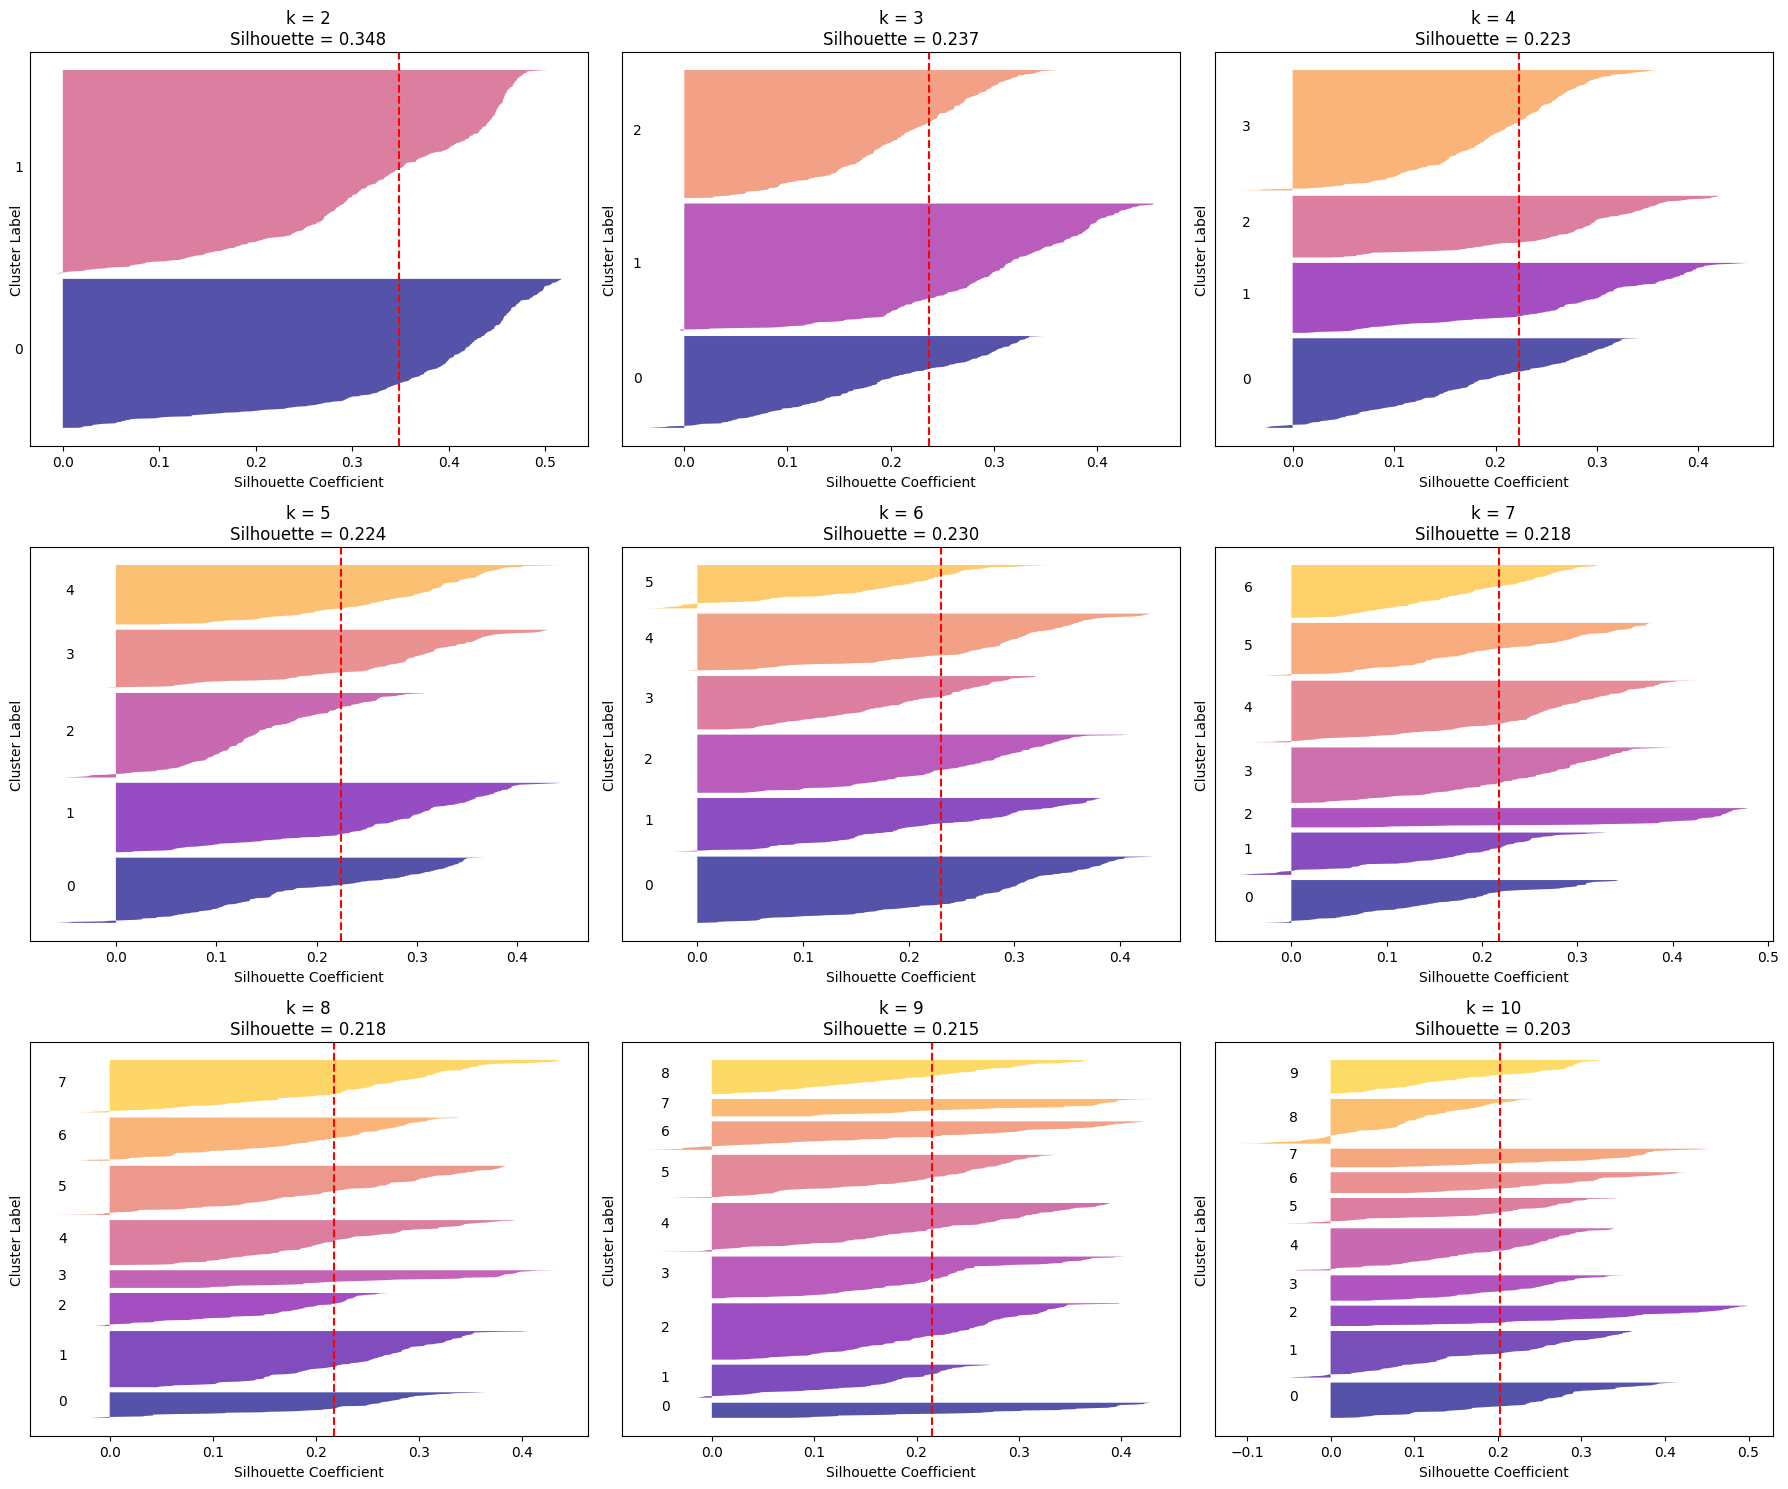

In [47]:
# Testing range of clusters using silhouette method

k_values = range(2, 11)

n_plots = len(k_values)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    ax = axes[idx]

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    sample_silhouette_values = silhouette_samples(X_pca, labels)
    avg_silhouette = silhouette_score(X_pca, labels)

    y_lower = 10
    for cluster in range(k):
        cluster_vals = sample_silhouette_values[labels == cluster]
        cluster_vals.sort()
        size_cluster = len(cluster_vals)
        y_upper = y_lower + size_cluster

        color = plt.cm.plasma(float(cluster) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, cluster_vals,
            facecolor=color,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        y_lower = y_upper + 10

    ax.axvline(x=avg_silhouette, color="red", linestyle="--")

    ax.set_title(f"k = {k}\nSilhouette = {avg_silhouette:.3f}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.set_yticks([])

for j in range(n_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('../images/silhouette_score.png')
plt.show()

## 1.6.1 Drawing conclusions from elbow method plots and silhouette scores

The elbow method indicated that the correct number of clusters could be anything between 3 and 5. The silhouette method indicates that the optimal number of clusters would be 2, with a score of 0.348. 2 clusters would provide a simple, high level separation of the dataset whereas 4 clusters give more detailed insights whilst maintaining distinct clusters.

I will continue with two potential k values and see how they look when they are plotted. For now I have put the value counts of each cluster in the output below:

In [48]:
# Define number of clusters to test
k_values = [2, 4]

final_models = {}
clustered_data = {}

for k in k_values:
    pipeline = create_pipeline(n_components=10, n_clusters=k)
    
    pipeline.fit(df_ml)
    
    labels = pipeline['kmeans'].labels_
    
    df_clustered = df_ml.copy()
    df_clustered[f'cluster_k{k}'] = labels
    
    final_models[k] = pipeline
    clustered_data[k] = df_clustered
    
    print(f"KMeans with k={k}")
    print(df_clustered[f'cluster_k{k}'].value_counts(), "\n")


KMeans with k=2
cluster_k2
1    405
0    297
Name: count, dtype: int64 

KMeans with k=4
cluster_k4
3    247
0    184
1    144
2    127
Name: count, dtype: int64 



## 1.7 Plot the clusters
We can now plot the clusters. The final pipeline for this project looks as follows:

In [49]:
# def create_pipeline(n_components=10, n_clusters=4):
#     '''
#     A pipeline created to scale and encode categoricals, 
#     set number of PCA components and clusters to be used with different parameters.
#     '''
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),  # assumes 'preprocessor' is already defined
#         ('pca', PCA(n_components=n_components)),
#         ('kmeans', KMeans(n_clusters=n_clusters, random_state=42, n_init=10))
#     ])
#     return pipeline

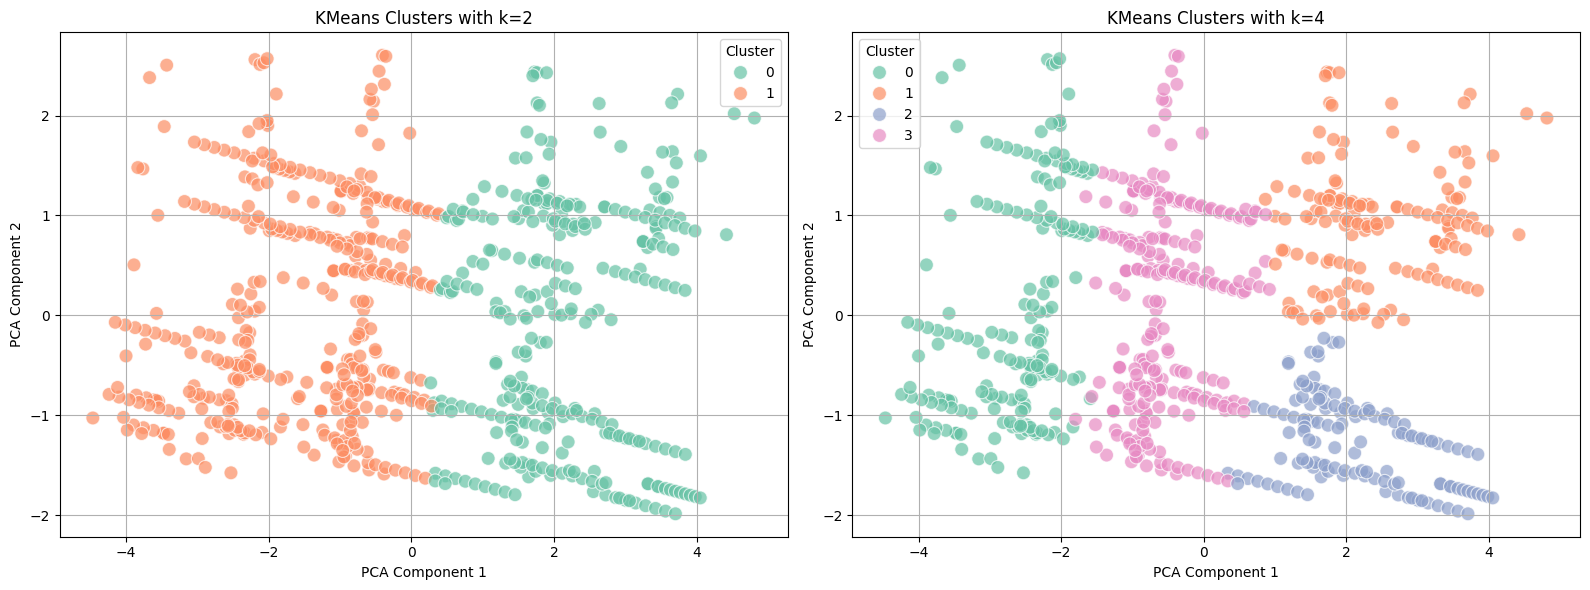

In [50]:
# Plot the clusters using both KMeans values
k_values = [2, 4]

fig, axes = plt.subplots(1, len(k_values), figsize=(16,6))

for idx, k in enumerate(k_values):
    X_pca = final_models[k]['pca'].transform(preprocessor.transform(df_ml))
    
    ax = axes[idx]
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=clustered_data[k][f'cluster_k{k}'],
        palette='Set2',
        s=100,
        alpha=0.7,
        ax=ax
    )
    
    ax.set_title(f'KMeans Clusters with k={k}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend(title='Cluster')
    ax.grid(True)

plt.tight_layout()
plt.savefig('../images/clusters_visualised.png')
plt.show()


Looking at those results, it backs up my the readings from the silhouette scores that 2 clusters would provide a simple, high level separation of the dataset whereas 4 clusters give more detailed insights whilst maintaining distinct clusters but there will be a small number of points that overlap. As I am trying to give insights into social media habits and other behaviours I will continue with 4 clusters.

## 1.8 Cluster profiling

In [51]:
# Add k=4 cluster labels
df_k4 = df_ml.copy()
df_k4["cluster"] = clustered_data[4]["cluster_k4"]

In [52]:
# Grouping by cluster and summarising numerical columns
num_summary_k4 = df_k4.groupby("cluster")[num_cols].mean().round(2)
num_summary_k4

,age,average_daily_usage_minutes,sleep_per_night_minutes,conflicts_over_social_media,addicted_score,mental_health_score
cluster,,,,,,
0,20.35,384.07,336.59,4.03,8.25,4.99
1,21.99,226.79,459.96,1.76,4.70,7.41
2,19.51,232.63,480.33,2.02,4.72,7.35
3,20.70,299.95,406.66,3.04,6.98,5.88


In [53]:
# Create categorical summary per cluster
cat_summary_k4 = {}

for col in cat_cols:
    summary = (
        df_k4.groupby("cluster")[col]
        .value_counts(normalize=True)
        .rename("proportion")
        .mul(100)
        .round(2)
        .unstack(fill_value=0)
    )
    cat_summary_k4[col] = summary

In [54]:
# Combine all categorical summaries into one dataframe 
cat_summary_combined = pd.concat(
    cat_summary_k4.values(),
    axis=1,
    keys=cat_summary_k4.keys()
)

cat_summary_combined = cat_summary_combined.sort_index()

cat_summary_combined


gender        relationship_status                         \
        Female   Male         Complicated In Relationship Single   
cluster                                                            
0        58.70  41.30                6.52           41.30  52.17   
1        18.06  81.94                4.17           65.97  29.86   
2        88.19  11.81                1.57           33.07  65.35   
3        42.51  57.49                4.86           29.96  65.18   

        academic_level                               country          ...  \
              Graduate High School Undergraduate Afghanistan Albania  ...   
cluster                                                               ...   
0                34.78       13.59         51.63        0.00     0.0  ...   
1                89.58        0.00         10.42        0.69     0.0  ...   
2                 0.00        1.57         98.43        0.00     0.0  ...   
3                53.04        0.00         46.96        0.00     0.4  ...   

        most_used_platform                                                    \
                  LinkedIn Snapchat TikTok Twitter VKontakte WeChat WhatsApp   
cluster                                                                        
0                     0.00     2.72  35.87    2.17      0.00   0.00    17.39   
1                    13.89     0.69   2.08    8.33      8.33   4.86     0.00   
2                     0.00     0.00  10.24    5.51      0.00   0.00     0.00   
3                     0.00     2.83  28.74    2.83      0.00   3.24     8.91   

                affects_academic_performance          
        YouTube                           No     Yes  
cluster                                               
0          0.54                         0.00  100.00  
1          3.47                        97.22    2.78  
2          1.57                        87.40   12.60  
3          0.81                         0.00  100.00  

[4 rows x 136 columns]

## 1.9 Cluster interpretations

### **Cluster 0**

* **Gender:** Balanced, slightly more female (59% Female, 41% Male).
* **Relationship Status:** Mostly single (52%), some in a relationship (41%), few complicated (7%).
* **Academic Level:** Spread across undergraduate (52%), graduate (35%), high school (14%).
* **Most Used Platforms:** Instagram and Facebook are popular, moderate TikTok usage.
* **Affects Academic Performance:** Likely minor impact (check exact percentages if needed).

**Interpretation:**
This cluster seems like average social media users: mixed gender, mostly single, undergraduates/graduates, moderate platform usage, with relatively low academic interference.

---

### **Cluster 1**

* **Gender:** Predominantly male (82%).
* **Relationship Status:** Mostly in a relationship (66%).
* **Academic Level:** Mostly graduates (90%), very few undergraduates or high school.
* **Most Used Platforms:** (Check percentages, likely professional/social networking platforms like LinkedIn).
* **Affects Academic Performance:** Likely low to moderate impact.

**Interpretation:**
This cluster could be older, professional-oriented users, mostly male, in relationships, high academic achievement, moderate social media usage that likely does not interfere with academics.

---

### **Cluster 2**

* **Gender:** Predominantly female (88%).
* **Relationship Status:** Mostly single (65%).
* **Academic Level:** Mostly undergraduates (98%).
* **Most Used Platforms:** Likely Instagram, TikTok, and Snapchat heavy.
* **Affects Academic Performance:** Check percentages; probably higher impact than Cluster 1.

**Interpretation:**
This cluster seems to represent young, highly engaged social media users, mostly single undergraduates, female-skewed. Social media might have a higher effect on academic performance.

---

### **Cluster 3**

* **Gender:** Mixed, slightly more male (57%).
* **Relationship Status:** Mixed, mostly single (65%).
* **Academic Level:** Mix of graduates and undergraduates (47%-53%).
* **Most Used Platforms:** Balanced usage across platforms.
* **Affects Academic Performance:** Likely moderate effect.

**Interpretation:**
This cluster is mixed users who are moderately engaged in social media, with some academic interference, and represent a general student population.

---

### Final Conclusion

1. Dimensionality Reduction & Preprocessing

* We reduced the dataset to 10 principal components using PCA, retaining ~86% of the variance.
* Numerical features were scaled, categorical features were one-hot encoded.
* PCA allowed KMeans to work efficiently without distortion from different feature scales.

2. Optimal Cluster Selection

* Elbow and silhouette analysis suggested 4 clusters as a good compromise between cohesion and separation.
* Silhouette scores showed clusters are reasonably well-separated.

3. Cluster Profiles (k = 4)

| Cluster | Key Characteristics                              | Social Media Usage                    | Academic Impact |
| ------- | ------------------------------------------------ | ------------------------------------- | --------------- |
| 0       | Balanced gender, mostly single, undergrad/grad   | Moderate across Instagram & Facebook  | Low             |
| 1       | Mostly male, in a relationship, mostly graduates | Likely professional/social networks   | Minimal         |
| 2       | Mostly female, single, undergraduates            | Heavy Instagram/TikTok/Snapchat usage | High            |
| 3       | Mixed gender, mostly single, mixed academics     | Balanced usage                        | Moderate        |

4. Implications

* Social media companies could target Cluster 2 for engagement strategies.
* Health and academic advisors could monitor Cluster 2 students for potential negative effects.
* Educational interventions could be customised based on cluster profiles.

---

AI assistance (e.g. Copilot / ChatGPT) was used during this notebook for:

- Creating cluster interpretations, profiling the traits users in each group would display
- Helped to interpret the elbow chart when there was no obvious 'elbow'
- Checking code quality, had it been written in the most efficient format

All AI-generated input was reviewed, validated, and modified to ensure correctness.